<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Predicting_Cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
import tensorflow
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical
import random



     |████████████████████████████████| 1.1 MB 8.7 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
data = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

data = pd.DataFrame(data)

# select Thailand only
data = data.loc[data['CountryName'] == "Thailand"]

# select columns
data = data[["Date", "ConfirmedCases"]]

# change date format
data.Date =  pd.to_datetime(data["Date"], format='%Y%m%d')

# reset index
data = data.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases
data[["ConfirmedCases"]] = data[["ConfirmedCases"]].replace(np.nan, 0)

# remove NaN rows (bottom part)
data = data.dropna()

# add daily cases columns
data[["Cases_daily"]] = data['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Cases_daily
data[["Cases_daily"]] = data[["Cases_daily"]].replace(np.nan, 0)


# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# remove the last rows with incomplete info
data = data.loc[~(data[["ConfirmedCases"]]==0).all(axis=1)]

# reset index
data = data.reset_index(drop = True)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
mob = read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

mob = pd.DataFrame(mob)

# select only Thailand
mob = mob.loc[mob['country_region'] == "Thailand"]

# select columns
mob = mob[["date",
              "retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline",
              "residential_percent_change_from_baseline"]]

# change date format
mob.date =  pd.to_datetime(mob["date"])

# change column name
mob = mob.rename(columns = {'date':'Date',
                            "retail_and_recreation_percent_change_from_baseline":'retail',
                            "grocery_and_pharmacy_percent_change_from_baseline": "grocery",
                            "parks_percent_change_from_baseline":'parks',
                            "transit_stations_percent_change_from_baseline":"transit",
                            "workplaces_percent_change_from_baseline":"workplace",
                            "residential_percent_change_from_baseline":"resident"})

# reset index
mob = mob.reset_index(drop = True)

# start from 15/6/2021
mob = mob[mob.loc[mob['Date'] == "2021-06-15"].index[0]:]

# reset index
mob = mob.reset_index(drop = True)

# omit Date column
mob = mob.drop(["Date"], axis = 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [9]:
apple = read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/applemobilitytrends.csv")

apple = pd.DataFrame(apple)

apple = apple.loc[apple['region'] == "Thailand"]

apple = apple.T

# select rows
apple = apple.drop(apple.index[[0,1,2,3,4,5]], axis= 0)

apple["Date"] = pd.to_datetime(apple.index)

# change column names
apple = apple.rename(columns= {135:"Driving", 136:"Walking"})

apple['Driving'] = apple['Driving'].astype(float, errors = 'raise')
apple['Walking'] = apple['Walking'].astype(float, errors = 'raise')

# start from 15/6/2021
apple = apple[apple.loc[apple['Date'] == "2021-06-15"].index[0]:]

apple = apple.reset_index(drop=True)

# omit Date column
apple0 = apple.drop(["Date", "Walking"], axis = 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.



In [15]:
# whichever has fewer data
length = min(len(data), len(mob), len(apple0))

# Deaths daily
data_i = pd.concat([data.Cases_daily[:length], 
                    data.Date[:length],
                    apple0[:length],
                    mob[:length]], axis = 1)

data_i = data_i.rename(columns = {"Cases_daily":"data_i"})
# data_i = data_i[data_i.loc[data_i['Date'] == "2021-06-15"].index[0]:]

# drop date column
data_i = data_i.drop(["Date"], axis = 1)

In [11]:
case = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

case = pd.DataFrame(case)

# select Thailand only
case = case.loc[case['CountryName'] == "Thailand"]

case = case[["Date", "ConfirmedCases"]]

# change date format
case.Date =  pd.to_datetime(case["Date"], format='%Y%m%d')

# reset index
case = case.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases
case[["ConfirmedCases"]] = case[["ConfirmedCases"]].replace(np.nan, 0)

# add daily cases columns
case[["Cases_daily"]] = case['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Cases_daily
case[["Cases_daily"]] = case[["Cases_daily"]].replace(np.nan, 0)

# start from 15/6/2021
case = case[case.loc[case['Date'] == "2021-06-15"].index[0]:]

# reset index
case = case.reset_index(drop = True)

# remove the last rows with incomplete info
case = case.loc[~(case[["ConfirmedCases"]]==0).all(axis=1)]

actual = case[case.loc[case['Date'] == "2021-06-15"].index[0]:]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [29]:
# use the previous 14 days to predict the next day
lag = 14
prediction = 1
window = 3 # for moving average
index = 30

data_i['data_i'] = data_i.data_i.rolling(window).mean()

data_i.dropna(subset = ["data_i"], inplace=True) # remove the first 2 rows

data_i = data_i.reset_index(drop = True)

# confirmed deaths
nrow_total = data_i.shape[0] - lag - prediction + 1
input_list = [np.expand_dims(data_i[i:lag+i], axis=0) for i in range(nrow_total)] 
X_i_p = np.concatenate(input_list, axis=0)

y_i_p = np.array([data_i.data_i[lag:data_i.shape[0]]])
y_i_p = y_i_p.T # transpose the matrix


# split into training and test sets
X_i_p_tr = X_i_p[0:index+1, :, :]
X_i_p_ts = X_i_p[index+1:data_i.shape[0], :, :]

y_i_p_tr = y_i_p[0:index+1]
y_i_p_ts = y_i_p[index+1:data_i.shape[0]]


In [20]:
# For predicting each variable (final part)
def split_sequence(sequence, lag):
  x, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + lag
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    x.append(seq_x)
    y.append(seq_y)
  return array(x), array(y)



In [24]:
# retail (univariate)
x_retail, y_retail = split_sequence(data_i.retail, lag)

# split into training and test sets
X_tr_retail = x_retail[0:index+1, :]
X_ts_retail = x_retail[index+1:x_retail.shape[0], :]
X_tr_retail = X_tr_retail.reshape(X_tr_retail.shape[0], X_tr_retail.shape[1], 1) # reshape input into 3D
X_ts_retail = X_ts_retail.reshape(X_ts_retail.shape[0], X_ts_retail.shape[1], 1)

y_tr_retail = y_retail[0:index+1]
y_ts_retail = y_retail[index+1:x_retail.shape[0]]
y_tr_retail = y_tr_retail.reshape(y_tr_retail.shape[0], 1, 1) # reshape output into 3D
y_ts_retail = y_ts_retail.reshape(y_ts_retail.shape[0], 1, 1) 

# grocery (univariate)
x_grocery, y_grocery = split_sequence(data_i.grocery, lag)

# split into training and test sets
X_tr_grocery = x_grocery[0:index+1, :]
X_ts_grocery = x_grocery[index+1:x_grocery.shape[0], :]
X_tr_grocery = X_tr_grocery.reshape(X_tr_grocery.shape[0], X_tr_grocery.shape[1], 1) # reshape input into 3D
X_ts_grocery = X_ts_grocery.reshape(X_ts_grocery.shape[0], X_ts_grocery.shape[1], 1)

y_tr_grocery = y_grocery[0:index+1]
y_ts_grocery = y_grocery[index+1:x_grocery.shape[0]]
y_tr_grocery = y_tr_grocery.reshape(y_tr_grocery.shape[0], 1, 1) # reshape output into 3D
y_ts_grocery = y_ts_grocery.reshape(y_ts_grocery.shape[0], 1, 1) 

# parks (univariate)
x_parks, y_parks = split_sequence(data_i.parks, lag)

# split into training and test sets
X_tr_parks = x_parks[0:index+1, :]
X_ts_parks = x_parks[index+1:x_parks.shape[0], :]
X_tr_parks = X_tr_parks.reshape(X_tr_parks.shape[0], X_tr_parks.shape[1], 1) # reshape input into 3D
X_ts_parks = X_ts_parks.reshape(X_ts_parks.shape[0], X_ts_parks.shape[1], 1)

y_tr_parks = y_parks[0:index+1]
y_ts_parks = y_parks[index+1:x_parks.shape[0]]
y_tr_parks = y_tr_parks.reshape(y_tr_parks.shape[0], 1, 1) # reshape output into 3D
y_ts_parks = y_ts_parks.reshape(y_ts_parks.shape[0], 1, 1) 


# transit (univariate)
x_transit, y_transit = split_sequence(data_i.transit, lag)

# split into training and test sets
X_tr_transit = x_transit[0:index+1, :]
X_ts_transit = x_transit[index+1:x_transit.shape[0], :]
X_tr_transit = X_tr_transit.reshape(X_tr_transit.shape[0], X_tr_transit.shape[1], 1) # reshape input into 3D
X_ts_transit = X_ts_transit.reshape(X_ts_transit.shape[0], X_ts_transit.shape[1], 1)

y_tr_transit = y_transit[0:index+1]
y_ts_transit = y_transit[index+1:x_transit.shape[0]]
y_tr_transit = y_tr_transit.reshape(y_tr_transit.shape[0], 1, 1) # reshape output into 3D
y_ts_transit = y_ts_transit.reshape(y_ts_transit.shape[0], 1, 1) 


# workplace (univariate)
x_workplace, y_workplace = split_sequence(data_i.workplace, lag)

# split into training and test sets
X_tr_workplace = x_workplace[0:index+1, :]
X_ts_workplace = x_workplace[index+1:x_workplace.shape[0], :]
X_tr_workplace = X_tr_workplace.reshape(X_tr_workplace.shape[0], X_tr_workplace.shape[1], 1) # reshape input into 3D
X_ts_workplace = X_ts_workplace.reshape(X_ts_workplace.shape[0], X_ts_workplace.shape[1], 1)

y_tr_workplace = y_workplace[0:index+1]
y_ts_workplace = y_workplace[index+1:x_workplace.shape[0]]
y_tr_workplace = y_tr_workplace.reshape(y_tr_workplace.shape[0], 1, 1) # reshape output into 3D
y_ts_workplace = y_ts_workplace.reshape(y_ts_workplace.shape[0], 1, 1) 


# resident (univariate)
x_resident, y_resident = split_sequence(data_i.resident, lag)

# split into training and test sets
X_tr_resident = x_resident[0:index+1, :]
X_ts_resident = x_resident[index+1:x_resident.shape[0], :]
X_tr_resident = X_tr_resident.reshape(X_tr_resident.shape[0], X_tr_resident.shape[1], 1) # reshape input into 3D
X_ts_resident = X_ts_resident.reshape(X_ts_resident.shape[0], X_ts_resident.shape[1], 1)

y_tr_resident = y_resident[0:index+1]
y_ts_resident = y_resident[index+1:x_resident.shape[0]]
y_tr_resident = y_tr_resident.reshape(y_tr_resident.shape[0], 1, 1) # reshape output into 3D
y_ts_resident = y_ts_resident.reshape(y_ts_resident.shape[0], 1, 1) 


# Driving (univariate)
x_Driving, y_Driving = split_sequence(data_i.Driving, lag)

# split into training and test sets
X_tr_Driving = x_Driving[0:index+1, :]
X_ts_Driving = x_Driving[index+1:x_Driving.shape[0], :]
X_tr_Driving = X_tr_Driving.reshape(X_tr_Driving.shape[0], X_tr_Driving.shape[1], 1) # reshape input into 3D
X_ts_Driving = X_ts_Driving.reshape(X_ts_Driving.shape[0], X_ts_Driving.shape[1], 1)

y_tr_Driving = y_Driving[0:index+1]
y_ts_Driving = y_Driving[index+1:x_Driving.shape[0]]
y_tr_Driving = y_tr_Driving.reshape(y_tr_Driving.shape[0], 1, 1) # reshape output into 3D
y_ts_Driving = y_ts_Driving.reshape(y_ts_Driving.shape[0], 1, 1) 

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [27]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 


In [30]:
# Multivariate CNN confirmed cases
kernel = [3, 5, 7]
pool = [2]
cnn_i_multi = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_p_tr, y_i_p_tr)
    cnn_i_multi.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_p_tr, y_i_p_tr)
    cnn_i_multi.append(score)

cnn_i_multi = pd.DataFrame(cnn_i_multi).T
cnn_i_multi.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 3.835
filter = 4, kernel size = 3, pooling size = 2: 4.574
filter = 8, kernel size = 3, pooling size = 2: 3.965
filter = 16, kernel size = 3, pooling size = 2: 3.721
filter = 32, kernel size = 3, pooling size = 2: 3.235
filter = 64, kernel size = 3, pooling size = 2: 3.053
filter = 128, kernel size = 3, pooling size = 2: 3.149
filter = 256, kernel size = 3, pooling size = 2: 3.791
filter = 512, kernel size = 3, pooling size = 2: 5.683
filter = 1024, kernel size = 3, pooling size = 2: 6.006
filter = 2, kernel size = 5, pooling size = 2: 4.148
filter = 4, kernel size = 5, pooling size = 2: 4.635
filter = 8, kernel size = 5, pooling size = 2: 3.928
filter = 16, kernel size = 5, pooling size = 2: 4.308
filter = 32, kernel size = 5, pooling size = 2: 3.585
filter = 64, kernel size = 5, pooling size = 2: 3.830
filter = 128, kernel size = 5, pooling size = 2: 4.453
filter = 256, kernel size = 5, pooling size = 2: 4.798
filter = 512, kernel size =

### LSTM

In [31]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

# Multivariate LSTM confirmed deaths

lstm_i_multi = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_p_tr, y_i_p_tr, i)
  lstm_i_multi.append(score)

### GRU

In [32]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate GRU confirmed deaths

gru_i_multi = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_p_tr, y_i_p_tr, i)
  gru_i_multi.append(score)

### RNNs

In [33]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# Multivariate RNNs confirmed deaths

rnn_i_multi = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_p_tr, y_i_p_tr, i)
  rnn_i_multi.append(score)

### Result Table

#### Multivariate Confirmed Deaths

In [34]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi[0],3), 
                                     round(gru_i_multi[0],3),
                                     round(rnn_i_multi[0],3), 
                                     round(cnn_i_multi.iloc[0,0],3),
                                     round(cnn_i_multi.iloc[0,1],3),
                                     round(cnn_i_multi.iloc[0,2],3),
                                     round(cnn_i_multi.iloc[0,3],3),
                                     round(cnn_i_multi.iloc[0,4],3),
                                     round(cnn_i_multi.iloc[0,5],3)],
                                     [round(lstm_i_multi[1],3), 
                                     round(gru_i_multi[1],3),
                                     round(rnn_i_multi[1],3), 
                                     round(cnn_i_multi.iloc[1,0],3),
                                     round(cnn_i_multi.iloc[1,1],3),
                                     round(cnn_i_multi.iloc[1,2],3),
                                     round(cnn_i_multi.iloc[1,3],3),
                                     round(cnn_i_multi.iloc[1,4],3),
                                     round(cnn_i_multi.iloc[1,5],3)],
                                     [round(lstm_i_multi[2],3), 
                                     round(gru_i_multi[2],3),
                                     round(rnn_i_multi[2],3), 
                                     round(cnn_i_multi.iloc[2,0],3),
                                     round(cnn_i_multi.iloc[2,1],3),
                                     round(cnn_i_multi.iloc[2,2],3),
                                     round(cnn_i_multi.iloc[2,3],3),
                                     round(cnn_i_multi.iloc[2,4],3),
                                     round(cnn_i_multi.iloc[2,5],3)],
                                     [round(lstm_i_multi[3],3), 
                                     round(gru_i_multi[3],3),
                                     round(rnn_i_multi[3],3), 
                                     round(cnn_i_multi.iloc[3,0],3),
                                     round(cnn_i_multi.iloc[3,1],3),
                                     round(cnn_i_multi.iloc[3,2],3),
                                     round(cnn_i_multi.iloc[3,3],3),
                                     round(cnn_i_multi.iloc[3,4],3),
                                     round(cnn_i_multi.iloc[3,5],3)],
                                     [round(lstm_i_multi[4],3), 
                                     round(gru_i_multi[4],3),
                                     round(rnn_i_multi[4],3), 
                                     round(cnn_i_multi.iloc[4,0],3),
                                     round(cnn_i_multi.iloc[4,1],3),
                                     round(cnn_i_multi.iloc[4,2],3),
                                     round(cnn_i_multi.iloc[4,3],3),
                                     round(cnn_i_multi.iloc[4,4],3),
                                     round(cnn_i_multi.iloc[4,5],3)],
                                     [round(lstm_i_multi[5],3), 
                                     round(gru_i_multi[5],3),
                                     round(rnn_i_multi[5],3), 
                                     round(cnn_i_multi.iloc[5,0],3),
                                     round(cnn_i_multi.iloc[5,1],3),
                                     round(cnn_i_multi.iloc[5,2],3),
                                     round(cnn_i_multi.iloc[5,3],3),
                                     round(cnn_i_multi.iloc[5,4],3),
                                     round(cnn_i_multi.iloc[5,5],3)],
                                     [round(lstm_i_multi[6],3), 
                                     round(gru_i_multi[6],3),
                                     round(rnn_i_multi[6],3), 
                                     round(cnn_i_multi.iloc[6,0],3),
                                     round(cnn_i_multi.iloc[6,1],3),
                                     round(cnn_i_multi.iloc[6,2],3),
                                     round(cnn_i_multi.iloc[6,3],3),
                                     round(cnn_i_multi.iloc[6,4],3),
                                     round(cnn_i_multi.iloc[6,5],3)],
                                     [round(lstm_i_multi[7],3), 
                                     round(gru_i_multi[7],3),
                                     round(rnn_i_multi[7],3), 
                                     round(cnn_i_multi.iloc[7,0],3),
                                     round(cnn_i_multi.iloc[7,1],3),
                                     round(cnn_i_multi.iloc[7,2],3),
                                     round(cnn_i_multi.iloc[7,3],3),
                                     round(cnn_i_multi.iloc[7,4],3),
                                     round(cnn_i_multi.iloc[7,5],3)],
                                     [round(lstm_i_multi[8],3), 
                                     round(gru_i_multi[8],3),
                                     round(rnn_i_multi[8],3), 
                                     round(cnn_i_multi.iloc[8,0],3),
                                     round(cnn_i_multi.iloc[8,1],3),
                                     round(cnn_i_multi.iloc[8,2],3),
                                     round(cnn_i_multi.iloc[8,3],3),
                                     round(cnn_i_multi.iloc[8,4],3),
                                     round(cnn_i_multi.iloc[8,5],3)],
                                     [round(lstm_i_multi[9],3), 
                                     round(gru_i_multi[9],3),
                                     round(rnn_i_multi[9],3), 
                                     round(cnn_i_multi.iloc[9,0],3),
                                     round(cnn_i_multi.iloc[9,1],3),
                                     round(cnn_i_multi.iloc[9,2],3),
                                     round(cnn_i_multi.iloc[9,3],3),
                                     round(cnn_i_multi.iloc[9,4],3),
                                     round(cnn_i_multi.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Deaths

In [46]:
seed(1)
tensorflow.random.set_seed(1)

model_multi_i = Sequential()
model_multi_i.add(SimpleRNN(32, activation = 'relu', input_shape=(X_i_p_tr.shape[1], X_i_p_tr.shape[2])))
# model_multi_i.add(Dense(2, activation = "relu"))
model_multi_i.add(Dense(1, activation = "linear"))
model_multi_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# model_multi_i = Sequential()
# model_multi_i.add(Conv1D(128, kernel_size = 5, activation = 'relu', input_shape=(X_i_p_tr.shape[1], X_i_p_tr.shape[2])))
# model_multi_i.add(MaxPooling1D(3))
# model_multi_i.add(Flatten())
# # model_multi_i.add(Dense(4, activation = "relu"))
# model_multi_i.add(Dense(1, activation = "linear"))
# model_multi_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_i.fit(X_i_p_tr, y_i_p_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_i1 = model_multi_i.evaluate(X_i_p_tr, y_i_p_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_i1[1])

scores_multi_i = model_multi_i.evaluate(X_i_p_ts, y_i_p_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_i[1])

MAPE: training =  2.148858070373535
MAPE: test =  18.857826232910156


In [36]:
# make a prediction
# training set
y_multi_i_tr = pd.DataFrame(model_multi_i.predict(X_i_p_tr))

# test set
y_multi_i_ts = pd.DataFrame(model_multi_i.predict(X_i_p_ts))

# combine training and test predictions
y_multi_i_total = pd.concat([y_multi_i_tr, y_multi_i_ts], ignore_index=True)


In [37]:
multi_ie = "RNNs"

### Plots

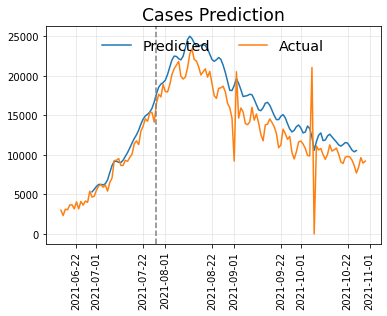

In [40]:

infect = pd.concat([y_multi_i_total,
                   data.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
infect.columns = ['multi_i', 'actual', 'Date']
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]


ax = plt.axes()
plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(data['Date'],data['Cases_daily'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Cases Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [47]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Deaths'],
                                                  [multi_ie],
                                    [round(scores_multi_i1[1],3)],
                                    [round(scores_multi_i[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

## Future Predictions

---



In [51]:
# Multivariate
def future_prediction_multi(input, model, days_predicted, total_prediction):
  all_prediction = pd.DataFrame(total_prediction)

  # use the last 14 days from actual data
  all_input = input[-14:]

  for i in range(1,days_predicted + 1):
    # create a matrix of input with 14 previous days for all features
    new_input = np.expand_dims(all_input[-14:], axis = 0) 

    # set seed
    seed(1)
    tensorflow.random.set_seed(1)

    # make the next day prediction
    last_output = pd.DataFrame(model.predict(new_input))

    # record the prediction
    all_prediction = pd.concat([all_prediction, pd.DataFrame(last_output)], ignore_index=True)


    # use resident to predict future resident using trained model
    new_driving = pd.DataFrame(model_apple.predict(np.array(all_input.iloc[-lag:, 1]).reshape(1,lag,1)))
    new_retail = pd.DataFrame(model_mob_retail.predict(np.array(all_input.iloc[-lag:, 2]).reshape(1,lag,1)))
    new_grocery = pd.DataFrame(model_mob_grocery.predict(np.array(all_input.iloc[-lag:, 3]).reshape(1,lag,1)))
    new_parks = pd.DataFrame(model_mob_parks.predict(np.array(all_input.iloc[-lag:, 4]).reshape(1,lag,1)))
    new_transit = pd.DataFrame(model_mob_transit.predict(np.array(all_input.iloc[-lag:, 5]).reshape(1,lag,1)))
    new_workplace = pd.DataFrame(model_mob_workplace.predict(np.array(all_input.iloc[-lag:, 6]).reshape(1,lag,1)))
    new_resident = pd.DataFrame(model_mob_resident.predict(np.array(all_input.iloc[-lag:, 7]).reshape(1,lag,1)))

    # new row
    new_row = [last_output[0], new_driving, new_retail, new_grocery, new_parks, new_transit, new_workplace, new_resident]
    new_row = list(itertools.chain(*new_row))

    # feed the new row back to data frame as new input
    all_input.loc[len(all_input)] = new_row
  return all_prediction



In [49]:
# train model for Driving
seed(1)
tensorflow.random.set_seed(1)

model_apple = Sequential()
model_apple.add(SimpleRNN(1024, activation='relu', input_shape=(X_tr_Driving.shape[1], X_tr_Driving.shape[2])))
model_apple.add(Dense(1, activation = "linear"))
model_apple.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_apple.fit(X_tr_Driving, y_tr_Driving, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


# train model for retail
seed(1)
tensorflow.random.set_seed(1)

model_mob_retail = Sequential()
model_mob_retail.add(LSTM(64, activation='relu', input_shape=(X_tr_retail.shape[1], X_tr_retail.shape[2])))
model_mob_retail.add(Dense(1, activation = "linear"))
model_mob_retail.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_retail.fit(X_tr_retail, y_tr_retail, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

# train model for grocery -- 
seed(1)
tensorflow.random.set_seed(1)

model_mob_grocery = Sequential()
model_mob_grocery.add(GRU(64, activation='relu', input_shape=(X_tr_grocery.shape[1], X_tr_grocery.shape[2])))
model_mob_grocery.add(Dense(1, activation = "linear"))
model_mob_grocery.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_grocery.fit(X_tr_grocery, y_tr_grocery, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

# train model for parks
seed(1)
tensorflow.random.set_seed(1)

model_mob_parks = Sequential()
model_mob_parks.add(Conv1D(512, kernel_size = 7, activation='relu', input_shape=(X_tr_parks.shape[1], X_tr_parks.shape[2])))
model_mob_parks.add(MaxPooling1D(2))
model_mob_parks.add(Flatten())
model_mob_parks.add(Dense(1, activation = "linear"))
model_mob_parks.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_parks.fit(X_tr_parks, y_tr_parks, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

# train model for transit
seed(1)
tensorflow.random.set_seed(1)

model_mob_transit = Sequential()
model_mob_transit.add(SimpleRNN(8, activation='relu', input_shape=(X_tr_transit.shape[1], X_tr_transit.shape[2])))
model_mob_transit.add(Dense(1, activation = "linear"))
model_mob_transit.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_transit.fit(X_tr_transit, y_tr_transit, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

# train model for workplace --
seed(1)
tensorflow.random.set_seed(1)

model_mob_workplace = Sequential()
model_mob_workplace.add(GRU(256, activation='relu', input_shape=(X_tr_workplace.shape[1], X_tr_workplace.shape[2])))
model_mob_workplace.add(Dense(1, activation = "linear"))
model_mob_workplace.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_workplace.fit(X_tr_workplace, y_tr_workplace, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


# train model for resident
seed(1)
tensorflow.random.set_seed(1)
model_mob_resident = Sequential()
model_mob_resident.add(SimpleRNN(128, activation='relu', input_shape=(X_tr_resident.shape[1], X_tr_resident.shape[2])))
model_mob_resident.add(Dense(1, activation = "linear"))
model_mob_resident.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_resident.fit(X_tr_resident, y_tr_resident, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


In [52]:
days_predicted = 25

# multivariate confirmed deaths
multi_i_pred = future_prediction_multi(data_i, model_multi_i, days_predicted, y_multi_i_total)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plots

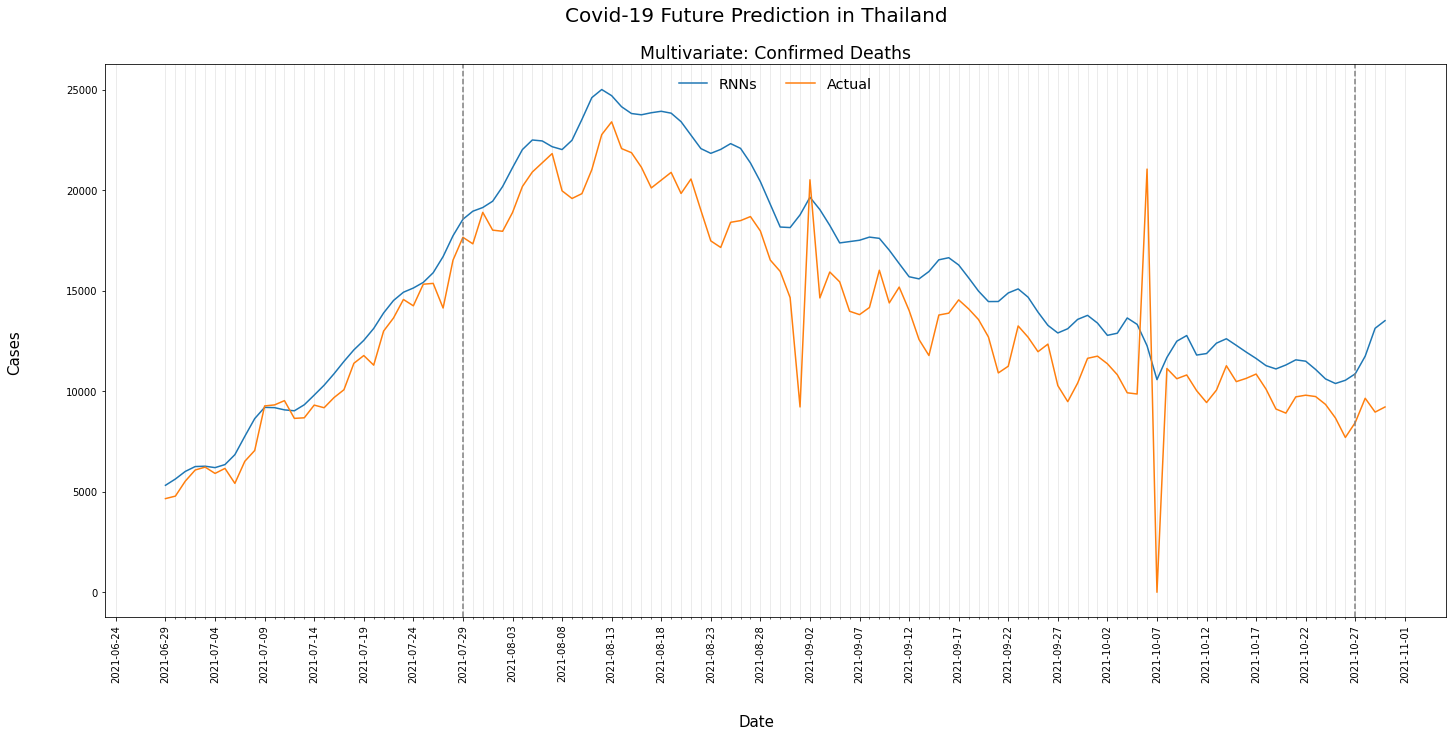

In [53]:

pred = pd.concat([multi_i_pred],
                 axis=1)
pred.columns = ['multi_i']

start_date = data.Date[lag]

# extract actual data
act = actual[(actual['Date'] >= start_date)].reset_index(drop = True)
act = act[0:len(pred)]


pred = pd.concat([pred, act], axis = 1)

date_test = pred['Date'][0+index]
date_predict = data['Date'][len(y_multi_i_total)+lag]
tick_spacing = 5

fig, axes = plt.subplots(figsize=(20,10)) 
fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)


# Multivariate confirmed deaths
axes.plot(pred['Date'],pred['multi_i'], label = multi_ie)
axes.plot(pred['Date'], pred['Cases_daily'], label = "Actual")
axes.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes.set_title("Multivariate: Confirmed Deaths", fontsize = 'xx-large')
axes.tick_params('x',labelrotation=90)
axes.axvline(date_test, color="gray", linestyle="--")
axes.axvline(date_predict, color="gray", linestyle="--")
axes.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes.set_xticks(pred['Date'], minor=True)
axes.xaxis.grid(True, which='both', alpha=0.3)

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()